In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline


In [126]:
# Set plot specs
def PlotSpecs(SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE):
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    colorArray = [plt.cm.tab20(0),plt.cm.tab20(6),plt.cm.tab20(13),plt.cm.tab20(19)]
    return colorArray

colorArray = PlotSpecs(10,12,14)

In [127]:
# Set paths
paths = ['./survey_results_public_2018.csv','./survey_results_public_2019.csv',
         './survey_results_public_2020.csv','./survey_results_public_2021.csv']

# Set desired Labels
labels = [['Employment','YearsCoding','Salary','Country','Student'],
          ['Employment','YearsCode','CompTotal','Country','Student'],
          ['Employment','YearsCode','CompTotal','Country','MainBranch'],
          ['Employment','YearsCode','CompTotal','Country','MainBranch']]

years = [2018,2019,2020,2021]

mostEconomicallyAffected = ['Brazil','Panama','Angola','Zambia','Namibia']

In [128]:
def CreateDataframe(pd,path):
    df = pd.read_csv(path,low_memory=False)   
    return df

def CreateSubDataframe(df,label):
    df = df[label]   
    return df

def RenameColumn(df,label):
    df.rename(columns={label[0]: 'Employment', label[1]: 'YearsCoding', label[2]: 'Salary'},inplace=True)
    return df

def CreateYearColumn(df,year):
    df['Year'] = year
    return df

def dropNanColumns(df):
    df = df.dropna(how='all', axis=1)  
    return df

# Load dataframes
df = [CreateDataframe(pd,path) for path in paths] 

# Create data subsets
df = [CreateSubDataframe(df[i],labels[i]) for i in range(len(years))] 

# Rename columns
df = [RenameColumn(df[i],labels[i]) for i in range(len(years))]

# Create 'year' column
df = [CreateYearColumn(df[i],years[i]) for i in range(len(years))]

# Not necessary: Drop columns with all NaN values
df = [dropNanColumns(df[i]) for i in range(len(years))]

# Merge into a single dataframe
newDf = pd.concat([df[0],df[1],df[2],df[3]],sort=False)

newDf.head()

,Employment,YearsCoding,Salary,Country,Student,Year,MainBranch
0,Employed part-time,3-5 years,NaN,Kenya,No,2018,NaN
1,Employed full-time,30 or more years,51000,United Kingdom,No,2018,NaN
2,Employed full-time,24-26 years,NaN,United States,No,2018,NaN
3,Employed full-time,18-20 years,NaN,United States,No,2018,NaN
4,Employed full-time,6-8 years,260000,South Africa,"Yes, part-time",2018,NaN


In [129]:
remapEmployment = {
    'Employed full-time':'Full-time',
    'Employed part-time':'Part-time',
    'Not employed, and not looking for work':'Not employed',
    'Not employed, but looking for work':'Not employed',
    'I prefer not to say':'NTD',
    'Independent contractor, freelancer, or self-employed':'Self-employed',
    'Retired':'Retired',
    'Student':'Student',
    'Student, full-time':'Student',
    'Student, part-time':'Student'}

employmentLabels = list(set(remapEmployment.values()))

# Employment analysis
# Question 1: Could the pandemic possibly have affected the Employment Status of programmers worldwide?

# Drop the rows with missing values
newDf = newDf.dropna(subset=['Employment'],how='any', axis=0)

# Rename some categorical values for uniformity and plot shortening
newDf['Employment'] = newDf['Employment'].astype('category')
newDf['Employment'].replace(remapEmployment,inplace=True)

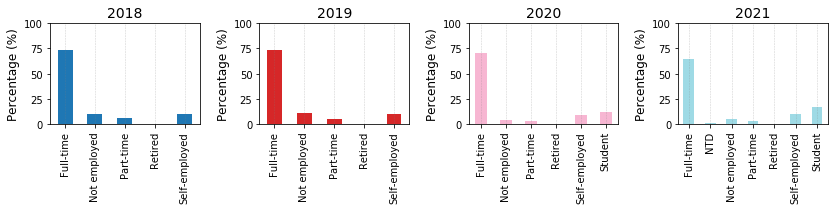

In [130]:
# Save results in countEmployment for further analysis
countEmployment = pd.DataFrame(index=employmentLabels)

# Plot figures
fig, axs = plt.subplots(1,4)

for i in range(len(years)):
    ax = (newDf.loc[newDf['Year'] == years[i]]['Employment'].value_counts().sort_index()*100
          /newDf.loc[newDf['Year'] == years[i]].shape[0]) 
    countEmployment[years[i]] = ax # Save results
    ax.plot(kind="bar",ax=fig.get_axes()[i],color=colorArray[i])
    fig.get_axes()[i].set_title(str(years[i]))
    fig.get_axes()[i].set_ylim(0,100)
    fig.get_axes()[i].set_ylabel('Percentage (%)')
    fig.get_axes()[i].set_yticks((0,25,50,75,100))
    fig.get_axes()[i].grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)
        
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=1.9,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.7)


In [131]:
def Num2Bin(string):
    try:
        num = int(string) 
        if (num <= 2):
            return '0-2 years'
        elif ((num >= 3) & (num <= 5)):
            return '3-5 years'
        elif ((num >= 6) & (num <= 8)):
            return '6-8 years'
        elif ((num >= 9) & (num <= 11)):
            return '9-11 years'
        elif ((num >= 12) & (num <= 14)):
            return '12-14 years'
        elif ((num >= 13) & (num <= 17)):
            return '15-17 years'
        elif ((num >= 18) & (num <= 20)):
            return '18-20 years'  
        elif ((num >= 21) & (num <= 23)):
            return '21-23 years'  
        elif ((num >= 24) & (num <= 26)):
            return '24-26 years' 
        elif ((num >= 27) & (num <= 29)):
            return '27-29 years' 
        else:
            return '30 or more years' 
    except:
        if (string == 'Less than 1 year'):
            return '0-2 years'
        elif (string == 'More than 50 years'):
            return '30 or more years'
        else:
            return string
    
binLabel = ['0-2 years','3-5 years','6-8 years',
            '9-11 years','12-14 years','15-17 years',
            '18-20 years','21-23 years','24-26 years',
            '27-29 years','30 or more years']

# Years Coding
# Question 2: Are there more programmers breaking into the field possibly because of the COVID-19 pandemic?

# Drop the rows with missing response values    
newDf = newDf.dropna(subset=['YearsCoding'],how='any', axis=0)

# Change bins for uniformity
newDf['YearsCoding'] = newDf['YearsCoding'].apply(Num2Bin)


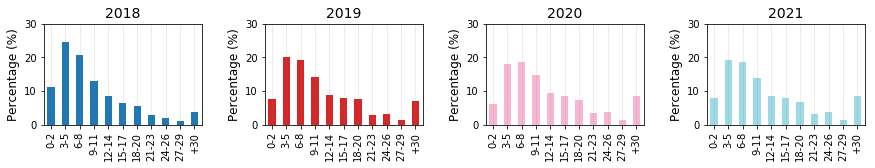

In [132]:
# Plot figures
fig, axs = plt.subplots(1,4)

# Save results for further analysis
countYearsCoding = pd.DataFrame(index = binLabel)

for i in range(len(years)):
    ax = (newDf.loc[newDf['Year'] == years[i]]['YearsCoding'].value_counts()*100
          /newDf.loc[newDf['Year'] == years[i]].shape[0]).reindex(index = binLabel)
    countYearsCoding[years[i]] = ax # Save results
    ax.plot(kind="bar",ax=fig.get_axes()[i],color=colorArray[i])
    fig.get_axes()[i].set_title(str(years[i]))
    fig.get_axes()[i].set_ylim(0,30)
    fig.get_axes()[i].set_ylabel('Percentage (%)')
    fig.get_axes()[i].get_xaxis().set_visible(True)
    fig.get_axes()[i].set_xticklabels(['0-2','3-5','6-8','9-11',
                                       '12-14','15-17','18-20','21-23',
                                       '24-26','27-29','+30'])
    fig.get_axes()[i].grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)
    
plt.subplots_adjust(left=0.1,
                    bottom=0.5,
                    right=2.0,
                    top=0.85,
                    wspace=0.4,
                    hspace=0.7)


In [133]:
# Question 3: Are the results different for respondents from countries whose economies were severely affected??
def IsAffectedCountry(string):
    if string in mostEconomicallyAffected: return 1
    else: return 0

# Create AffectedCountry flag
newDf['AffectedCountry'] = newDf['Country'].apply(IsAffectedCountry)
newDfSubset = newDf.loc[newDf['AffectedCountry']==1]

# Show results
newDfSubset.loc[newDfSubset['Year'] == 2021].head()

,Employment,YearsCoding,Salary,Country,Student,Year,MainBranch,AffectedCountry
19,Full-time,12-14 years,NaN,Brazil,NaN,2021,"I used to be a developer by profession, but no...",1
45,Full-time,21-23 years,22000,Brazil,NaN,2021,I am a developer by profession,1
296,Full-time,12-14 years,3200,Brazil,NaN,2021,I am a developer by profession,1
352,Full-time,9-11 years,NaN,Brazil,NaN,2021,I am a developer by profession,1
534,Full-time,15-17 years,35000,Brazil,NaN,2021,I am a developer by profession,1


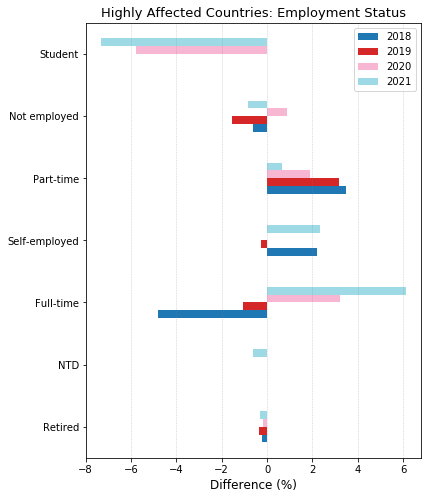

In [134]:
# Employment Status: Plot figures
countEmploymentAffected = pd.DataFrame(index=employmentLabels)
fig = plt.figure(figsize=(6,8))

for i in range(len(years)):
    ax = (newDfSubset.loc[newDfSubset['Year'] == years[i]]['Employment'].value_counts().sort_index()*100
          /newDfSubset.loc[newDfSubset['Year'] == years[i]].shape[0])
    countEmploymentAffected[years[i]] = ax

countEmploymentAffected.fillna(value=0,inplace=True)    
affectedDiff = countEmploymentAffected.subtract(countEmployment)

# Plot figure
affectedDiff.plot.barh(ax=plt.axes(),colormap=plt.cm.tab20)
plt.xlabel('Difference (%)')
plt.title('Highly Affected Countries: Employment Status',fontsize=13)
plt.grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)

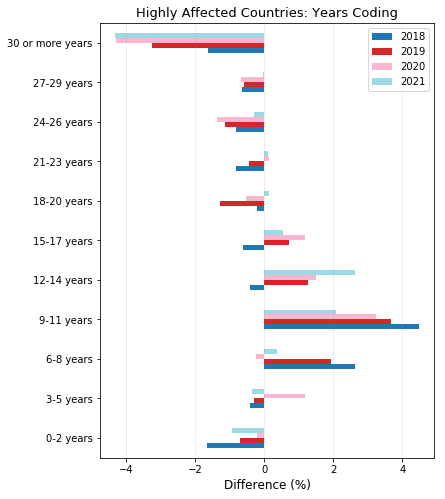

In [135]:
# Years Coding
fig = plt.figure(figsize=(6,8))
countYearsCodingAffected = pd.DataFrame(index = binLabel)

for i in range(len(years)):
    ax = (newDfSubset.loc[newDfSubset['Year'] == years[i]]['YearsCoding'].
          value_counts()*100/newDfSubset.loc[newDfSubset['Year'] == years[i]].shape[0]) 
    countYearsCodingAffected[years[i]] = ax
     
countYearsCodingAffected.fillna(value=0,inplace=True)
affectedDiff = countYearsCodingAffected.subtract(countYearsCoding)

# Plot figure   
p = affectedDiff.plot.barh(ax=plt.axes(),colormap=plt.cm.tab20)
plt.xlabel('Difference (%)')
plt.title('Highly Affected Countries: Years Coding',fontsize=13)
plt.grid(axis = 'x', color = 'gray', alpha = 0.4, linestyle = '--', linewidth = 0.5)
